# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

### Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [3]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Data.csv", header= None)

print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:8191,3:].values
        y = data_matrix.iloc[0:8191,0].values
        
        # Add normalization for x
        x = preprocessing.normalize(x)
        print(x)

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)

       0    1    2             3         4         5         6         7    \
0      2.3  0.2    1  1.507010e-26  0.012809  0.025618  0.038426  0.051234   
1      2.4  0.2    1 -1.908640e-26  0.012808  0.025616  0.038423  0.051230   
2      2.5  0.2    1  1.076793e-27  0.012807  0.025614  0.038421  0.051226   
3      2.6  0.2    1 -2.257969e-27  0.012806  0.025613  0.038418  0.051223   
4      2.7  0.2    1 -2.748220e-26  0.012806  0.025611  0.038416  0.051220   
...    ...  ...  ...           ...       ...       ...       ...       ...   
8215  35.3  2.1    1  3.612701e-25  0.019995  0.039982  0.059951  0.079893   
8216  35.3  2.2    1  6.935291e-25  0.020404  0.040799  0.061176  0.081524   
8217  35.3  2.3    1  5.082584e-25  0.020808  0.041606  0.062385  0.083133   
8218  35.4  0.2    1  2.791266e-24  0.012794  0.025587  0.038381  0.051174   
8219  35.4  0.3    1  1.262741e-23  0.012958  0.025916  0.038873  0.051830   

           8         9    ...       155       156       157    

### Deside to apply host or device

In [4]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Define the functions we need

In [5]:
def loss_cal_per_epoch(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def train(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_cal_per_epoch(loss_train, model, train_loader)
        loss_cal_per_epoch(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)
    plt.plot(x, loss_train, 'b-', label="training loss")
    plt.plot(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score


### Train PhysicsNet

epoch 1: train_loss = 384.3715, val_loss = 409.3900
epoch 2: train_loss = 321.1073, val_loss = 336.8753
epoch 3: train_loss = 243.2097, val_loss = 262.8041
epoch 4: train_loss = 172.5598, val_loss = 185.0055
epoch 5: train_loss = 131.0035, val_loss = 142.0968
epoch 6: train_loss = 112.7700, val_loss = 124.4006
epoch 7: train_loss = 105.5634, val_loss = 113.0780
epoch 8: train_loss = 102.0210, val_loss = 109.6416
epoch 9: train_loss = 101.1859, val_loss = 105.7625
epoch 10: train_loss = 97.4724, val_loss = 100.4996
epoch 11: train_loss = 97.3380, val_loss = 101.1969
epoch 12: train_loss = 92.5065, val_loss = 97.4765
epoch 13: train_loss = 93.4533, val_loss = 99.6852
epoch 14: train_loss = 92.2551, val_loss = 95.6799
epoch 15: train_loss = 90.3556, val_loss = 97.1709
epoch 16: train_loss = 89.3725, val_loss = 95.9587
epoch 17: train_loss = 90.6099, val_loss = 95.5221
epoch 18: train_loss = 88.9788, val_loss = 93.9893
epoch 19: train_loss = 87.9597, val_loss = 95.7988
epoch 20: train_loss

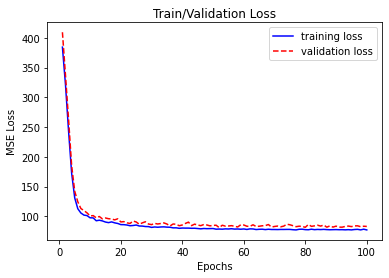

In [8]:
in_channel = 162
node_1 = 256
node_2 = 256
node_3 = 128
node_4 = 64
out_channel = 1

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

### Visualization of outcomes

In [13]:
model_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_trained, x_test_example)

# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:8])
print("Prediction    =", score_example[:8].reshape(1, 8))

Ground Truths = tensor([33.7000, 18.4000,  7.4000, 28.6000, 27.9000, 13.3000,  9.7000, 34.3000])
Prediction    = tensor([[17.8167, 18.2857, 18.2144, 17.6725, 17.6725, 18.1907, 18.1782, 18.0335]])
